In [1]:
import sys
import os
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML, display
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
# import regionmask
import rioxarray
from shapely.geometry import mapping # , Point, Polygon
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import pprint

In [2]:
# Define project repo path
inDirName = '/Users/smurugan9/research/aislens/aislens_emulation/'

# Data file paths
regriddedFluxSSH_filepath = 'data/interim/RegriddedFluxSSH.nc' # Data containing regridded flux and SSH for 150 years
iceShelvesShape_filepath = 'data/interim/iceShelves.geojson' # File contains all defined ice shelves
figures_folderpath = 'reports/figures/' # Folder for output figures

In [3]:
data = xr.open_dataset(inDirName + regriddedFluxSSH_filepath)
flux = data.timeMonthly_avg_landIceFreshwaterFlux
ssh = data.timeMonthly_avg_ssh
lat = data.lat
lon = data.lon

In [4]:
# Read geoJSON region feature file as GeoDataFrame
iceshelvesmask = gpd.read_file(inDirName + iceShelvesShape_filepath)

In [5]:
# Convert to south polar stereographic projection
icems = iceshelvesmask.to_crs({'init': 'epsg:3031'})
crs = ccrs.SouthPolarStereo()

# Specify projection for data file
data.rio.write_crs("epsg:3031",inplace=True)

/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<xarray.Dataset>
Dimensions:                                (y: 601, x: 601, time: 1800)
Coordinates:
    lat                                    (y, x) float64 ...
    lon                                    (y, x) float64 ...
  * time                                   (time) datetime64[ns] 2001-01-31 ....
  * x                                      (x) float64 -3e+06 ... 3e+06
  * y                                      (y) float64 -3e+06 ... 3e+06
    spatial_ref                            int64 0
Data variables:
    timeMonthly_avg_landIceFreshwaterFlux  (time, y, x) float64 ...
    timeMonthly_avg_ssh                    (time, y, x) float64 ...
Attributes:
    history:   Wed Oct 27 15:35:43 2021: ncrcat RegriddedFluxSSH.0001-01-01.n...
    meshName:  6000.0x6000.0km_10.0km_Antarctic_stereo
    NCO:       netCDF Operators version 5.0.3 (Homepage = http://nco.sf.net, ...

In [6]:
## Following section tests the code for 1 ice shelf / catchment:
# Iceshelf chosen: 
#  34 : Amery
# 103 : Ronne
# 104 : Western Ross
# 105 : Eastern Ross
# 114 : Thwaites

basin = 34
basinName = icems.name.values[basin]

In [7]:
# Mask data to chosen basin
ds = data.rio.clip(icems.loc[[basin],'geometry'].apply(mapping),icems.crs,drop=False)

In [8]:
flx = ds.timeMonthly_avg_landIceFreshwaterFlux
h = ds.timeMonthly_avg_ssh

In [9]:
flx_series = flx.sum(['y','x'])

In [10]:
clm = flx.groupby('time.month').mean(dim='time')
anm = flx.groupby('time.month') - clm

In [11]:
glob_ts = anm.sum(("x", "y"), skipna=True)

In [12]:
# Running mean and standard deviation

globSD = glob/glob.std(dim='time')
rglobSD = globSD.rolling(time=7,center=True).mean('time')

NameError: name 'glob' is not defined

In [13]:
def detrend_dim(data, dim, deg):
    # detrend along a single dimension
    p = data.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(data[dim], p.polyfit_coefficients)
    return data - fit

In [14]:
# Running mean for detrending
# ranm = anm.rolling(time=7,center=True).mean('time')
rdanm = detrend_dim(anm, 'time', 1)

In [15]:
anm_ts = anm.sum(['y','x'])

In [16]:
rdanm_ts = rdanm.sum(['y','x'])

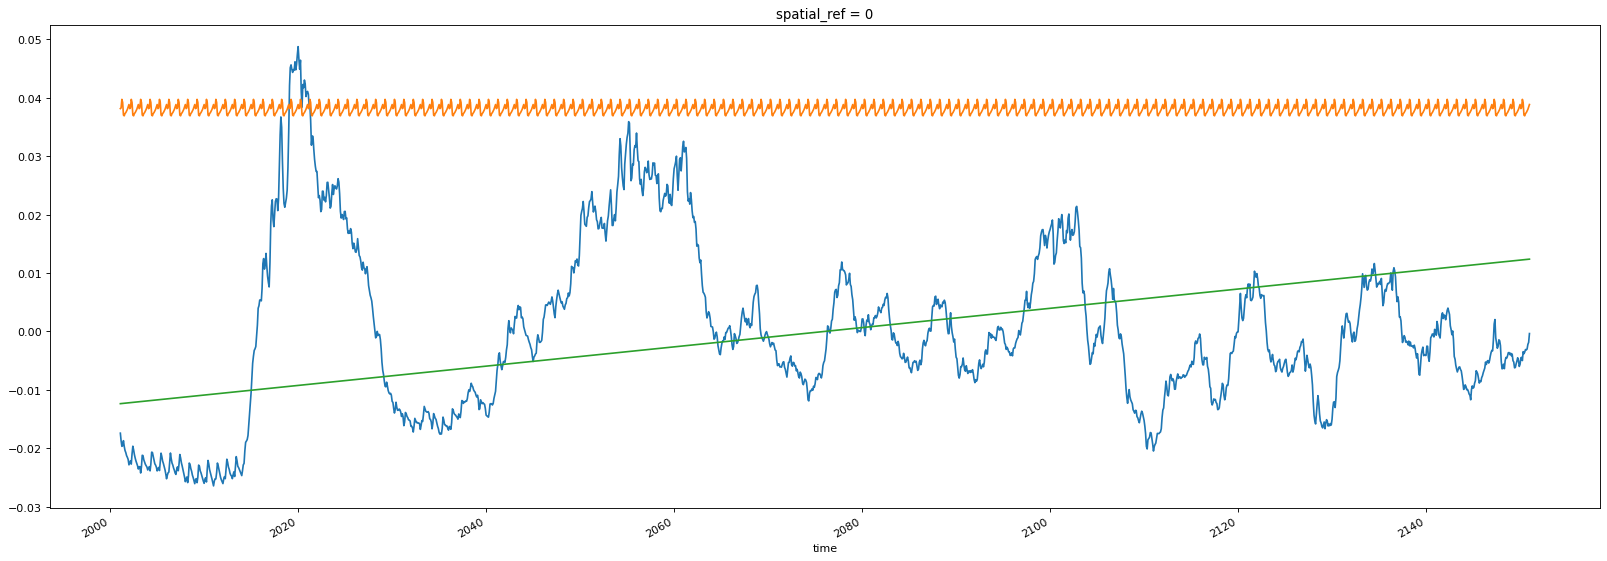

In [31]:
plt.figure(figsize=(25, 8), dpi=80)
#glob_ts.plot()
#globSD.plot()
#rglobSD.plot()
# anm_ts.plot()
rdanm_ts.plot()

diff = anm_ts - rdanm_ts
diff2 = flx_series - anm_ts

diff2.plot()
diff.plot()

In [ ]:
# Plot inset

fig = plt.figure(figsize=(10, 8), dpi=80)
ax = plt.axes()
ax.plot(flx_dtr_ts[60:1200])
plt.title('Raw Detrended Flux')

# Label the axis
ax.set_xlabel('Time')
ax.set_ylabel('Flux')


#I want to select the x-range for the zoomed region
x1 = 500
x2 = 800

# select y-range for zoomed region
y1 = -0.02
y2 = 0.05

# Make the zoom-in plot:
axins = zoomed_inset_axes(ax, 1, loc=1) # zoom = 2
axins.plot(flx_dtr_ts[60:1200])
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")